# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

- transformer の output と feature を SVR で学習する。
    - NN の head と SVR でアンサンブルする。 [Link](https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8/notebook)
- swin base, large と CSWin と B7 でアンサンブル。
- ConvMixer [Link](https://github.com/tmp-iclr/convmixer)

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import pickle
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
# Additional local libraries

# https://github.com/microsoft/CSWin-Transformer
sys.path.append("../input/CSWin-Transformer")

import models

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [7]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🛠 Config

In [9]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [10]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    train = True
    train2 = False  # SVR
    train3 = False  # 100 or not
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model examples

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnet_b7_ns
- tf_efficientnetv2_l_in21k
- swin_base_patch4_window12_384_in22k
- swin_large_patch4_window7_224_in22k
- swin_large_patch4_window12_384_in22k
- CSWin_144_24322_large_384

In [11]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 10,
    "es_patience": 0,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-5,
    "min_lr": 1e-6,
    "weight_decay": 1e-7,
    "momentum": 0.9,
    "model_name": "swin_base_patch4_window7_224_in22k",
    "size": 224,
    "models": [
        # "swin_large_patch4_window12_384_in22k:v14",
        # "swin_base_patch4_window12_384_in22k:v1",
    ],
    "runs": [
        # "34qor14i",  # swin large 384 v14
        # "tmbsq7j1",  # swin base 384 v1
        # "1ngzxqt1",  # swin large 224
    ],
}

In [12]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [13]:
if Config.train:
    wandb_job_type = "training"

elif Config.train2:
    wandb_job_type = "training2"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [14]:
if Config.debug:
    wandb_tags.append("debug")

# if Config.amp:
#     wandb_tags.append("amp")

In [15]:
wandb_tags.append("no feats")
wandb_tags.append("bins kfold")
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("cutmix")
# wandb_tags.append("freeze norm")
# wandb_tags.append("crop image")

In [16]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [17]:
config = wandb.config

# EDA 1

In [18]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

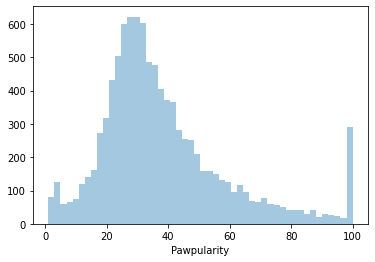

In [19]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [20]:
def train_preprocess(df):
    df["Pawpularity100"] = np.where(df["Pawpularity"] == 100, 1, 0)

    return df

In [21]:
if Config.train3:
    train = train_preprocess(df)
    train["Pawpularity100"].value_counts()

# EDA 2

# 👑 Load Artifacts

In [22]:
if Config.train2:
    api = wandb.Api()
    for artifact_id in config.models:
        name_version = artifact_id.replace(":", "-")
        if not os.path.exists(name_version):
            os.makedirs(name_version)

        try:
            artifact_path = f"{Config.wandb_entity}/{Config.wandb_project}/{artifact_id}"
            artifact = api.artifact(artifact_path)
            artifact.download(name_version)
        except Exception as e:
            print(f"Error: {artifact_path}, {e}")

In [23]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["Id", "preds"]]
        oof.columns = ["Id", f"preds{n}"]
        train = pd.merge(train, oof, on="Id")

    print(train.columns)

In [24]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [25]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [26]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [27]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [28]:
if "crop image" in wandb_tags:
    TRAIN_IMAGE_PATH = DATA_DIR + "crop/"

In [29]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [30]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transform

In [31]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

In [32]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## CutMix

In [33]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(x, feats, y, alpha=1.0, use_cuda=True):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    return mixed_x, mixed_feats, y_a, y_b, lam

In [34]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = cutmix(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

## MixUp

In [35]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [36]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

# 🚗 Model

## Base model

In [37]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        if "no feats" in wandb_tags:
            self.head2 = nn.Linear(128, config.n_class)
        else:
            self.dropout = nn.Dropout(0.1)
            self.head1 = nn.Linear(140, 64)
            self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        if "no feats" in wandb_tags:
            x = self.head2(x)
        else:
            x = self.dropout(x)
            x = torch.cat([x, feats], dim=1)
            x = self.head1(x)
        return x

In [38]:
def train_mode(model):
    model.train()

    # Freeze layer normalization
    if any(key in config.model_name for key in ["vit", "swin", "CSWin"]):
        for m in model.modules():
            for child in m.children():
                if isinstance(child, nn.LayerNorm):
                    for param in child.parameters():
                        param.requires_grad = False

In [39]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [40]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

## Backbone model

In [41]:
class BackboneModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        # x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        # x = self.head1(x)
        # x = self.head2(x)
        return x

In [42]:
if Config.debug and config.model_name != "":
    model = BackboneModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

# Optimizer

In [43]:
# https://github.com/davda54/sam/blob/main/sam.py
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Loss

In [44]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [45]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [47]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

## Early stopping

In [48]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            if self.patience <= 0:
                return
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Grad norm

In [49]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

## Training

In [50]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

            if "SAM" in config.optimizer:

                def closure():
                    # y_preds = model(images, features)
                    y_preds = model(images, features).squeeze(1)

                    if "mixup" in wandb_tags and mix_decision < 0.5:
                        loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
                    else:
                        loss = criterion(y_preds, labels)

                    loss.backward()
                    return loss

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            if "SAM" in config.optimizer:
                scaler.step(optimizer, closure)
            else:
                scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad()
            scheduler.step()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.2e}  "
            )

    return losses.avg

## Validation

In [51]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

## Training2 (Inference by backbone)

In [52]:
def train2_inference_fn(data_loader, model, device):
    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(data_loader):
        images = images.to(device)
        features = features.to(device)

        with torch.no_grad():
            y_preds = model(images, features)
            # y_preds = model(images, features).squeeze(1)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(data_loader) - 1):
            print(
                f"EVAL: [{step}/{len(data_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(data_loader)):s} "
            )

    predictions = np.concatenate(preds)
    return predictions

# Postprocess

# 🏃‍♂️ Train loop

In [53]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "SAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
            )
        elif config.optimizer == "ASAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
                rho=2.0,
                adaptive=True,
            )
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# 🏃‍♂️🏃‍♂️ Train2 loop

In [54]:
def train2_loop(df, artifact_id, fold):
    LOGGER.info(f"========== ID: {artifact_id} fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    valid_labels = valid_folds["Pawpularity"].values

    # ====================================================
    # Model
    # ====================================================
    model_name = artifact_id.split(":")[0]
    model = BackboneModel(model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    path = f"{artifact_id.replace(':', '-')}/{model_name}_fold{fold}_best.pth"
    model.load_state_dict(torch.load(path))

    # ====================================================
    # Inference by backbone
    # ====================================================

    train_preds = train2_inference_fn(train_loader, model, device)
    valid_preds = train2_inference_fn(valid_loader, model, device)

    scaler = StandardScaler()
    # scaler.fit(np.vstack([train_preds, valid_preds]))

    train_norm = scaler.fit_transform(train_preds)
    valid_norm = scaler.transform(valid_preds)

    scaler_path = MODEL_DIR + f"{model_name}-StandardScaler_fold{fold}_best.pkl"
    pickle.dump(scaler, open(scaler_path, "wb"))

    # ====================================================
    # Tuning SVR parameters
    # ====================================================
    # https://github.com/hkaneko1985/fastoptsvrhyperparams/blob/master/fastoptsvrhyperparams.ipynb
    start_time = time.time()

    svr_epss = 2 ** np.arange(-10, 1, dtype=float)  # Candidates of epsilon
    svr_cs = 2 ** np.arange(-5, 11, dtype=float)  # Candidates of C
    svr_gammas = 2 ** np.arange(-20, 11, dtype=float)  # Candidates of gamma

    # Optimize epsilon with cross-validation
    model_tune_eps = GridSearchCV(SVR(kernel="rbf", C=3), {"epsilon": svr_epss}, verbose=1)
    model_tune_eps.fit(train_norm, train_dataset.labels)
    optimal_eps = model_tune_eps.best_params_["epsilon"]
    elapsed = time.time() - start_time
    print(f"Optimized eps: {elapsed:.0f}s")

    # Optimize C with cross-validation
    model_tune_c = GridSearchCV(SVR(kernel="rbf", epsilon=optimal_eps), {"C": svr_cs}, verbose=1)
    model_tune_c.fit(train_norm, train_dataset.labels)
    optimal_c = model_tune_c.best_params_["C"]
    elapsed = time.time() - start_time
    print(f"Optimized c: {elapsed:.0f}s")

    # Optimize gamma with cross-validation (optional)
    model_tune_gamma = GridSearchCV(
        SVR(kernel="rbf", epsilon=optimal_eps, C=optimal_c), {"gamma": svr_gammas}, verbose=1
    )
    model_tune_gamma.fit(train_norm, train_dataset.labels)
    optimal_gamma = model_tune_gamma.best_params_["gamma"]
    elapsed = time.time() - start_time
    print(f"Optimized gamma: {elapsed:.0f}s")

    best_params = {
        "C": optimal_c,
        "epsilon": optimal_eps,
        "gamma": optimal_gamma,
    }
    print(f"{best_params}")

    param_path = MODEL_DIR + f"{model_name}-SVR-params_fold{fold}_best.json"
    with open(param_path, "w") as f:
        json.dump(best_params, f, indent=4)

    # ====================================================
    # Training SVR
    # ====================================================
    start_time = time.time()

    model_svr = SVR(C=optimal_c, epsilon=optimal_eps, gamma=optimal_gamma)
    model_svr.fit(train_norm, train_dataset.labels)

    preds = model_svr.predict(valid_norm)
    preds *= 100.0

    # scoring
    # score = get_score(valid_labels, preds.argmax(1))
    score = get_score(valid_labels, preds)

    elapsed = time.time() - start_time
    LOGGER.info(f"Score: {score}  time: {elapsed:.0f}s")

    svr_path = MODEL_DIR + f"{model_name}-SVR_fold{fold}_best.pkl"
    pickle.dump(model_svr, open(svr_path, "wb"))

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    # valid_folds["preds"] = es.best_preds
    valid_folds["preds"] = preds

    return valid_folds, score

# Main function

In [55]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

    # ====================================================
    # Validation
    # ====================================================
    if Config.validate:
        cols = [f"preds{n}" for n in range(len(config.runs))]
        train["preds"] = train[cols].values.mean(axis=1)

        LOGGER.info(f"========== CV ==========")
        get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    # ====================================================
    # Training SVR
    # ====================================================
    if Config.train2:
        oof_df = pd.DataFrame()
        oof_result = []
        for n, artifact_id in enumerate(config.models):

            for fold in range(config.n_fold):
                seed_torch(seed + fold)
                _oof_df, score = train2_loop(train, artifact_id, fold)
                oof_df = pd.concat([oof_df, _oof_df])

                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, fold)

            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)

            break

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(f"{artifact_id.split(':')[0]}-SVR", type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [56]:
main()

========== fold: 0 training ==========


Epoch: [1][0/139] Elapsed 0m 28s (remain 64m 38s) Loss: 0.7065 Grad: 1.3585 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 15s (remain 0m 28s) Loss: 0.6547 Grad: 0.5462 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6526 Grad: 0.6455 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6592 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6438 


Epoch 1 - avg_train_loss: 0.6526  avg_val_loss: 0.6438  time: 99s
Epoch 1 - Score: 17.934272989495916


Validation loss decreased (inf --> 0.643831).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 6s) Loss: 0.6237 Grad: 0.6831 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6386 Grad: 0.5302 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6386 Grad: 0.5598 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6545 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6410 


Epoch 2 - avg_train_loss: 0.6386  avg_val_loss: 0.6410  time: 75s
Epoch 2 - Score: 17.545837913443602


Validation loss decreased (0.643831 --> 0.641009).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 30s) Loss: 0.6529 Grad: 1.0248 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6492 Grad: 1.1608 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6485 Grad: 0.6672 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6613 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6433 


Epoch 3 - avg_train_loss: 0.6485  avg_val_loss: 0.6433  time: 75s
Epoch 3 - Score: 17.815067346738157


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 30s) Loss: 0.6546 Grad: 1.1039 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6447 Grad: 0.5391 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6447 Grad: 0.7621 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6613 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6408 


Epoch 4 - avg_train_loss: 0.6447  avg_val_loss: 0.6408  time: 76s
Epoch 4 - Score: 17.50157841890283


Validation loss decreased (0.641009 --> 0.640753).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 16s) Loss: 0.6656 Grad: 0.6591 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6425 Grad: 0.6864 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6430 Grad: 0.8706 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6639 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6433 


Epoch 5 - avg_train_loss: 0.6430  avg_val_loss: 0.6433  time: 77s
Epoch 5 - Score: 17.8003883725943


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 41s) Loss: 0.6501 Grad: 0.9715 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6425 Grad: 0.8188 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6421 Grad: 1.7663 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6635 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6431 


Epoch 6 - avg_train_loss: 0.6421  avg_val_loss: 0.6431  time: 76s
Epoch 6 - Score: 17.786109393962242


Epoch: [7][0/139] Elapsed 0m 2s (remain 6m 4s) Loss: 0.6359 Grad: 0.7675 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6417 Grad: 0.6539 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6412 Grad: 0.8476 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6639 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6417 


Epoch 7 - avg_train_loss: 0.6412  avg_val_loss: 0.6417  time: 77s
Epoch 7 - Score: 17.60670610599091


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 42s) Loss: 0.6441 Grad: 0.7436 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6401 Grad: 0.9992 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6400 Grad: 0.6614 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6649 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6433 


Epoch 8 - avg_train_loss: 0.6400  avg_val_loss: 0.6433  time: 77s
Epoch 8 - Score: 17.780824821506076


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 20s) Loss: 0.6360 Grad: 0.6477 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6275 Grad: 0.9761 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6280 Grad: 1.1237 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6634 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6412 


Epoch 9 - avg_train_loss: 0.6280  avg_val_loss: 0.6412  time: 77s
Epoch 9 - Score: 17.540011835623606


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 42s) Loss: 0.6416 Grad: 0.5104 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6272 Grad: 0.5360 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6261 Grad: 0.6374 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6632 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6413 


Epoch 10 - avg_train_loss: 0.6261  avg_val_loss: 0.6413  time: 76s
Epoch 10 - Score: 17.541708785441458
========== fold: 0 result ==========
Score: 17.50158
========== fold: 1 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 6m 1s) Loss: 0.6824 Grad: 1.3781 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6558 Grad: 0.4962 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6528 Grad: 0.6166 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6292 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6422 


Epoch 1 - avg_train_loss: 0.6528  avg_val_loss: 0.6422  time: 75s
Epoch 1 - Score: 17.93286587466181


Validation loss decreased (inf --> 0.642179).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 39s) Loss: 0.6539 Grad: 0.4654 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 50s (remain 0m 18s) Loss: 0.6383 Grad: 0.5564 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6388 Grad: 0.9347 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6255 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6393 


Epoch 2 - avg_train_loss: 0.6388  avg_val_loss: 0.6393  time: 75s
Epoch 2 - Score: 17.54193921201767


Validation loss decreased (0.642179 --> 0.639263).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 16s) Loss: 0.6648 Grad: 0.6940 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6466 Grad: 0.7453 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6464 Grad: 0.7159 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6249 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6393 


Epoch 3 - avg_train_loss: 0.6464  avg_val_loss: 0.6393  time: 75s
Epoch 3 - Score: 17.543145822563297


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 44s) Loss: 0.6638 Grad: 0.8000 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 50s (remain 0m 18s) Loss: 0.6440 Grad: 1.1473 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6440 Grad: 0.7152 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6245 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6440  avg_val_loss: 0.6393  time: 74s
Epoch 4 - Score: 17.539626601530486


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 31s) Loss: 0.6420 Grad: 1.3139 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 50s (remain 0m 18s) Loss: 0.6435 Grad: 0.8789 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6429 Grad: 0.7526 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6265 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6397 


Epoch 5 - avg_train_loss: 0.6429  avg_val_loss: 0.6397  time: 74s
Epoch 5 - Score: 17.599147829976644


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 24s) Loss: 0.6445 Grad: 1.0438 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6423 Grad: 0.7036 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6416 Grad: 1.3292 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6216 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6404 


Epoch 6 - avg_train_loss: 0.6416  avg_val_loss: 0.6404  time: 76s
Epoch 6 - Score: 17.684649331779625


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 37s) Loss: 0.6340 Grad: 0.4736 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6414 Grad: 0.9685 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6399 Grad: 0.5534 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6222 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6392 


Epoch 7 - avg_train_loss: 0.6399  avg_val_loss: 0.6392  time: 76s
Epoch 7 - Score: 17.535771788170457


Validation loss decreased (0.639263 --> 0.639223).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 37s) Loss: 0.6398 Grad: 0.5536 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6385 Grad: 0.7248 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6401 Grad: 1.0408 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6218 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6393 


Epoch 8 - avg_train_loss: 0.6401  avg_val_loss: 0.6393  time: 76s
Epoch 8 - Score: 17.546722258037057


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 34s) Loss: 0.6276 Grad: 0.5071 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6281 Grad: 0.7180 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6276 Grad: 0.4344 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6234 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6389 


Epoch 9 - avg_train_loss: 0.6276  avg_val_loss: 0.6389  time: 76s
Epoch 9 - Score: 17.492828875761965


Validation loss decreased (0.639223 --> 0.638880).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 21s) Loss: 0.6062 Grad: 0.5640 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6259 Grad: 0.5697 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6256 Grad: 0.5578 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6235 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6391 


Epoch 10 - avg_train_loss: 0.6256  avg_val_loss: 0.6391  time: 74s
Epoch 10 - Score: 17.520974516703664
========== fold: 1 result ==========
Score: 17.49283
========== fold: 2 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 43s) Loss: 0.6965 Grad: 1.9779 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6554 Grad: 0.4990 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6528 Grad: 0.8247 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6396 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6511 


Epoch 1 - avg_train_loss: 0.6528  avg_val_loss: 0.6511  time: 75s
Epoch 1 - Score: 19.075339717405193


Validation loss decreased (inf --> 0.651070).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 17s) Loss: 0.6519 Grad: 0.9212 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 50s (remain 0m 18s) Loss: 0.6389 Grad: 0.8726 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6388 Grad: 0.5069 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6360 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6442 


Epoch 2 - avg_train_loss: 0.6388  avg_val_loss: 0.6442  time: 74s
Epoch 2 - Score: 18.276379312198426


Validation loss decreased (0.651070 --> 0.644181).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 56s) Loss: 0.6673 Grad: 1.1030 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6463 Grad: 0.8808 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6464 Grad: 0.6857 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6398 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6446 


Epoch 3 - avg_train_loss: 0.6464  avg_val_loss: 0.6446  time: 75s
Epoch 3 - Score: 18.316905350640052


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 34s) Loss: 0.6485 Grad: 0.9041 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6444 Grad: 1.1818 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6448 Grad: 0.6198 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6374 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6437 


Epoch 4 - avg_train_loss: 0.6448  avg_val_loss: 0.6437  time: 78s
Epoch 4 - Score: 18.220930766044017


Validation loss decreased (0.644181 --> 0.643749).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 54s) Loss: 0.6410 Grad: 0.6070 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6411 Grad: 0.7432 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6424 Grad: 0.6358 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6357 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6443 


Epoch 5 - avg_train_loss: 0.6424  avg_val_loss: 0.6443  time: 75s
Epoch 5 - Score: 18.277512114146184


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 31s) Loss: 0.6398 Grad: 1.1189 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6418 Grad: 0.8708 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6414 Grad: 0.6979 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6377 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6445 


Epoch 6 - avg_train_loss: 0.6414  avg_val_loss: 0.6445  time: 76s
Epoch 6 - Score: 18.304428553886805


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 18s) Loss: 0.6543 Grad: 0.6989 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6411 Grad: 0.6336 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6405 Grad: 0.7254 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6380 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6447 


Epoch 7 - avg_train_loss: 0.6405  avg_val_loss: 0.6447  time: 75s
Epoch 7 - Score: 18.317193045313992


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 41s) Loss: 0.6240 Grad: 0.5525 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6407 Grad: 0.6892 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6401 Grad: 1.0042 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6382 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6443 


Epoch 8 - avg_train_loss: 0.6401  avg_val_loss: 0.6443  time: 75s
Epoch 8 - Score: 18.28278427754682


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 33s) Loss: 0.6209 Grad: 0.4860 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6284 Grad: 0.5262 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6272 Grad: 0.5846 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6389 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6447 


Epoch 9 - avg_train_loss: 0.6272  avg_val_loss: 0.6447  time: 75s
Epoch 9 - Score: 18.325510337186106


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 38s) Loss: 0.6148 Grad: 0.5131 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6265 Grad: 0.9425 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6254 Grad: 0.7249 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6397 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6453 


Epoch 10 - avg_train_loss: 0.6254  avg_val_loss: 0.6453  time: 74s
Epoch 10 - Score: 18.38411582814505
========== fold: 2 result ==========
Score: 18.22093
========== fold: 3 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 6m 21s) Loss: 0.6997 Grad: 1.2401 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6563 Grad: 0.5251 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6536 Grad: 0.4476 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6497 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6431 


Epoch 1 - avg_train_loss: 0.6536  avg_val_loss: 0.6431  time: 75s
Epoch 1 - Score: 17.92101706479351


Validation loss decreased (inf --> 0.643077).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 34s) Loss: 0.6326 Grad: 0.4961 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6393 Grad: 0.5428 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6392 Grad: 0.8906 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6500 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6391 


Epoch 2 - avg_train_loss: 0.6392  avg_val_loss: 0.6391  time: 74s
Epoch 2 - Score: 17.39517159865656


Validation loss decreased (0.643077 --> 0.639078).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 24s) Loss: 0.6809 Grad: 1.0693 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 49s (remain 0m 18s) Loss: 0.6466 Grad: 0.7421 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6471 Grad: 0.6252 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6481 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6394 


Epoch 3 - avg_train_loss: 0.6471  avg_val_loss: 0.6394  time: 74s
Epoch 3 - Score: 17.43027533369699


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 31s) Loss: 0.6565 Grad: 0.8476 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6458 Grad: 0.8334 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6455 Grad: 0.8512 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6476 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6384 


Epoch 4 - avg_train_loss: 0.6455  avg_val_loss: 0.6384  time: 75s
Epoch 4 - Score: 17.30538340254332


Validation loss decreased (0.639078 --> 0.638410).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 35s) Loss: 0.6570 Grad: 1.0722 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6425 Grad: 0.8634 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 11s (remain 0m 0s) Loss: 0.6428 Grad: 0.8186 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6463 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6386 


Epoch 5 - avg_train_loss: 0.6428  avg_val_loss: 0.6386  time: 78s
Epoch 5 - Score: 17.329014790593014


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 31s) Loss: 0.6439 Grad: 0.5227 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6443 Grad: 1.8258 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6424 Grad: 0.7628 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6489 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6390 


Epoch 6 - avg_train_loss: 0.6424  avg_val_loss: 0.6390  time: 78s
Epoch 6 - Score: 17.36888627934202


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 25s) Loss: 0.6398 Grad: 0.7820 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6415 Grad: 0.5827 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6408 Grad: 0.7925 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6474 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6386 


Epoch 7 - avg_train_loss: 0.6408  avg_val_loss: 0.6386  time: 78s
Epoch 7 - Score: 17.317372795389545


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 49s) Loss: 0.6431 Grad: 0.6775 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6409 Grad: 2.6162 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6404 Grad: 1.0752 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6477 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6386 


Epoch 8 - avg_train_loss: 0.6404  avg_val_loss: 0.6386  time: 77s
Epoch 8 - Score: 17.31998529101936


Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 16s) Loss: 0.6181 Grad: 0.7457 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6278 Grad: 0.4585 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6282 Grad: 0.6767 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6478 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6385 


Epoch 9 - avg_train_loss: 0.6282  avg_val_loss: 0.6385  time: 78s
Epoch 9 - Score: 17.30954340358647


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 40s) Loss: 0.6245 Grad: 0.9658 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6269 Grad: 0.3636 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6264 Grad: 0.6182 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6465 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6381 


Epoch 10 - avg_train_loss: 0.6264  avg_val_loss: 0.6381  time: 76s
Epoch 10 - Score: 17.254662752456575


Validation loss decreased (0.638410 --> 0.638069).  Saving model ...


========== fold: 3 result ==========
Score: 17.25466
========== fold: 4 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 6m 36s) Loss: 0.6705 Grad: 1.0274 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6522 Grad: 0.8989 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6501 Grad: 0.4260 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6460 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6431 


Epoch 1 - avg_train_loss: 0.6501  avg_val_loss: 0.6431  time: 77s
Epoch 1 - Score: 18.114996218521593


Validation loss decreased (inf --> 0.643144).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 45s) Loss: 0.6076 Grad: 0.7609 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6378 Grad: 0.7478 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6376 Grad: 0.8891 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6461 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6425 


Epoch 2 - avg_train_loss: 0.6376  avg_val_loss: 0.6425  time: 78s
Epoch 2 - Score: 18.016188510934953


Validation loss decreased (0.643144 --> 0.642498).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 22s) Loss: 0.6463 Grad: 1.2677 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6459 Grad: 2.0284 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6466 Grad: 1.0653 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6450 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6413 


Epoch 3 - avg_train_loss: 0.6466  avg_val_loss: 0.6413  time: 78s
Epoch 3 - Score: 17.884599665510784


Validation loss decreased (0.642498 --> 0.641291).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 11s) Loss: 0.6343 Grad: 0.7900 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6438 Grad: 0.7266 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6434 Grad: 0.5943 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6414 


Epoch 4 - avg_train_loss: 0.6434  avg_val_loss: 0.6414  time: 77s
Epoch 4 - Score: 17.880583250689078


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6479 Grad: 0.8170 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6426 Grad: 0.6075 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6420 Grad: 0.9804 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6420 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6408 


Epoch 5 - avg_train_loss: 0.6420  avg_val_loss: 0.6408  time: 77s
Epoch 5 - Score: 17.821475253816452


Validation loss decreased (0.641291 --> 0.640826).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6548 Grad: 0.9269 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6428 Grad: 0.8110 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6425 Grad: 0.7072 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6419 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6402 


Epoch 6 - avg_train_loss: 0.6425  avg_val_loss: 0.6402  time: 78s
Epoch 6 - Score: 17.733011305017257


Validation loss decreased (0.640826 --> 0.640196).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 47s) Loss: 0.6372 Grad: 0.5483 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6413 Grad: 2.3193 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6407 Grad: 0.8949 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6405 


Epoch 7 - avg_train_loss: 0.6407  avg_val_loss: 0.6405  time: 77s
Epoch 7 - Score: 17.772019636826027


Epoch: [8][0/139] Elapsed 0m 2s (remain 6m 25s) Loss: 0.6475 Grad: 0.9098 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6384 Grad: 0.8281 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6388 Grad: 1.1782 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6410 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6406 


Epoch 8 - avg_train_loss: 0.6388  avg_val_loss: 0.6406  time: 78s
Epoch 8 - Score: 17.778970802259288


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 58s) Loss: 0.6138 Grad: 0.5136 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6263 Grad: 0.7010 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6274 Grad: 0.7227 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6425 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6405 


Epoch 9 - avg_train_loss: 0.6274  avg_val_loss: 0.6405  time: 77s
Epoch 9 - Score: 17.77915050887943


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 55s) Loss: 0.6334 Grad: 0.5123 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6250 Grad: 0.5325 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6251 Grad: 0.6038 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6420 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6408 


Epoch 10 - avg_train_loss: 0.6251  avg_val_loss: 0.6408  time: 77s
Epoch 10 - Score: 17.806402097450245
========== fold: 4 result ==========
Score: 17.73301
========== fold: 5 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 58s) Loss: 0.7256 Grad: 1.7738 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6572 Grad: 0.5092 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6539 Grad: 0.6546 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6581 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6432 


Epoch 1 - avg_train_loss: 0.6539  avg_val_loss: 0.6432  time: 78s
Epoch 1 - Score: 17.846917851357162


Validation loss decreased (inf --> 0.643247).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 23s) Loss: 0.6447 Grad: 0.5737 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6404 Grad: 0.6461 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6394 Grad: 1.8644 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6528 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6399 


Epoch 2 - avg_train_loss: 0.6394  avg_val_loss: 0.6399  time: 78s
Epoch 2 - Score: 17.378613846193936


Validation loss decreased (0.643247 --> 0.639863).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 40s) Loss: 0.6456 Grad: 0.6446 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6467 Grad: 0.9855 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6470 Grad: 1.2325 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6542 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6410 


Epoch 3 - avg_train_loss: 0.6470  avg_val_loss: 0.6410  time: 77s
Epoch 3 - Score: 17.49433295931116


Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 14s) Loss: 0.6514 Grad: 1.1241 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6455 Grad: 0.9935 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6444 Grad: 0.6698 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6541 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6444  avg_val_loss: 0.6393  time: 77s
Epoch 4 - Score: 17.282833289391313


Validation loss decreased (0.639863 --> 0.639279).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 6m 14s) Loss: 0.6248 Grad: 0.4858 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6417 Grad: 0.4989 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6428 Grad: 0.6023 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6534 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6382 


Epoch 5 - avg_train_loss: 0.6428  avg_val_loss: 0.6382  time: 77s
Epoch 5 - Score: 17.153754526753634


Validation loss decreased (0.639279 --> 0.638185).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 6m 0s) Loss: 0.6421 Grad: 0.5644 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6419 Grad: 0.6166 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6421 Grad: 0.4741 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6519 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6380 


Epoch 6 - avg_train_loss: 0.6421  avg_val_loss: 0.6380  time: 77s
Epoch 6 - Score: 17.12356805798342


Validation loss decreased (0.638185 --> 0.637987).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 45s) Loss: 0.6531 Grad: 0.8007 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6402 Grad: 1.2622 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6412 Grad: 0.9488 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6509 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6383 


Epoch 7 - avg_train_loss: 0.6412  avg_val_loss: 0.6383  time: 76s
Epoch 7 - Score: 17.153726291540035


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 22s) Loss: 0.6372 Grad: 0.8386 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6393 Grad: 0.6728 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6392 Grad: 0.5028 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6528 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6385 


Epoch 8 - avg_train_loss: 0.6392  avg_val_loss: 0.6385  time: 75s
Epoch 8 - Score: 17.17314718693254


Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 30s) Loss: 0.6058 Grad: 0.5502 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6287 Grad: 0.6900 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6286 Grad: 0.6965 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6538 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6386 


Epoch 9 - avg_train_loss: 0.6286  avg_val_loss: 0.6386  time: 75s
Epoch 9 - Score: 17.18195932166567


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6127 Grad: 0.5682 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6280 Grad: 1.0473 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6272 Grad: 0.8186 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6541 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6384 


Epoch 10 - avg_train_loss: 0.6272  avg_val_loss: 0.6384  time: 77s
Epoch 10 - Score: 17.167063909113587
========== fold: 5 result ==========
Score: 17.12357
========== fold: 6 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 54s) Loss: 0.6884 Grad: 1.2856 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6542 Grad: 0.7419 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6508 Grad: 0.6316 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6647 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6443 


Epoch 1 - avg_train_loss: 0.6508  avg_val_loss: 0.6443  time: 75s
Epoch 1 - Score: 17.96388401104775


Validation loss decreased (inf --> 0.644266).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 30s) Loss: 0.6446 Grad: 0.6509 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6371 Grad: 0.7038 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6377 Grad: 0.8448 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6593 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6410 


Epoch 2 - avg_train_loss: 0.6377  avg_val_loss: 0.6410  time: 76s
Epoch 2 - Score: 17.5387287740129


Validation loss decreased (0.644266 --> 0.641037).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 6m 0s) Loss: 0.6810 Grad: 1.0119 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6463 Grad: 0.7867 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6467 Grad: 0.4965 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6575 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6394 


Epoch 3 - avg_train_loss: 0.6467  avg_val_loss: 0.6394  time: 76s
Epoch 3 - Score: 17.322928464976407


Validation loss decreased (0.641037 --> 0.639435).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 6m 2s) Loss: 0.6318 Grad: 0.6977 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6431 Grad: 1.8834 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6438 Grad: 0.7303 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6615 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6398 


Epoch 4 - avg_train_loss: 0.6438  avg_val_loss: 0.6398  time: 76s
Epoch 4 - Score: 17.373206216695866


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 52s) Loss: 0.6517 Grad: 0.9100 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6428 Grad: 0.6671 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6425 Grad: 0.9537 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6565 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6385 


Epoch 5 - avg_train_loss: 0.6425  avg_val_loss: 0.6385  time: 75s
Epoch 5 - Score: 17.199418018155914


Validation loss decreased (0.639435 --> 0.638542).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 59s) Loss: 0.6462 Grad: 0.7149 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6420 Grad: 0.7111 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6411 Grad: 1.5143 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6576 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6396 


Epoch 6 - avg_train_loss: 0.6411  avg_val_loss: 0.6396  time: 76s
Epoch 6 - Score: 17.33618220322285


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 51s) Loss: 0.6443 Grad: 0.6589 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6403 Grad: 0.8163 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6405 Grad: 0.8656 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6553 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6387 


Epoch 7 - avg_train_loss: 0.6405  avg_val_loss: 0.6387  time: 75s
Epoch 7 - Score: 17.22651389246708


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 55s) Loss: 0.6515 Grad: 0.5151 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6390 Grad: 0.8080 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6395 Grad: 0.7067 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6563 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6394 


Epoch 8 - avg_train_loss: 0.6395  avg_val_loss: 0.6394  time: 76s
Epoch 8 - Score: 17.308175849548224


Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 1s) Loss: 0.6477 Grad: 0.6980 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6265 Grad: 0.5868 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6273 Grad: 0.6025 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6562 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6387 


Epoch 9 - avg_train_loss: 0.6273  avg_val_loss: 0.6387  time: 77s
Epoch 9 - Score: 17.220799568140453


Epoch: [10][0/139] Elapsed 0m 2s (remain 6m 23s) Loss: 0.6376 Grad: 2.0736 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6255 Grad: 0.5494 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6254 Grad: 0.9411 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6578 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6396 


Epoch 10 - avg_train_loss: 0.6254  avg_val_loss: 0.6396  time: 76s
Epoch 10 - Score: 17.326863829410993
========== fold: 6 result ==========
Score: 17.19942
========== fold: 7 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 53s) Loss: 0.7081 Grad: 1.4627 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6562 Grad: 0.7620 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6527 Grad: 0.4880 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6297 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6451 


Epoch 1 - avg_train_loss: 0.6527  avg_val_loss: 0.6451  time: 76s
Epoch 1 - Score: 18.29434649279823


Validation loss decreased (inf --> 0.645124).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 22s) Loss: 0.6410 Grad: 0.7584 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6392 Grad: 1.6154 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6386 Grad: 0.8461 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6287 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6461 


Epoch 2 - avg_train_loss: 0.6386  avg_val_loss: 0.6461  time: 75s
Epoch 2 - Score: 18.387845623980404


Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 54s) Loss: 0.6434 Grad: 1.0311 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6473 Grad: 0.7270 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6481 Grad: 0.9793 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6275 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6435 


Epoch 3 - avg_train_loss: 0.6481  avg_val_loss: 0.6435  time: 76s
Epoch 3 - Score: 18.07538406480238


Validation loss decreased (0.645124 --> 0.643484).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 50s) Loss: 0.6601 Grad: 1.0301 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6447 Grad: 0.5802 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6445 Grad: 0.6461 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6282 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6428 


Epoch 4 - avg_train_loss: 0.6445  avg_val_loss: 0.6428  time: 76s
Epoch 4 - Score: 17.97886011020475


Validation loss decreased (0.643484 --> 0.642769).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 39s) Loss: 0.6532 Grad: 0.8394 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6430 Grad: 2.8845 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6438 Grad: 0.7786 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6310 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6444 


Epoch 5 - avg_train_loss: 0.6438  avg_val_loss: 0.6444  time: 76s
Epoch 5 - Score: 18.183638283823


Epoch: [6][0/139] Elapsed 0m 2s (remain 5m 49s) Loss: 0.6340 Grad: 0.6752 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6410 Grad: 0.9593 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6415 Grad: 0.8199 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 32s) Loss: 0.6312 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6432 


Epoch 6 - avg_train_loss: 0.6415  avg_val_loss: 0.6432  time: 75s
Epoch 6 - Score: 18.0286914422038


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 47s) Loss: 0.6490 Grad: 0.5756 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6397 Grad: 0.9763 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6409 Grad: 0.7115 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6313 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6430 


Epoch 7 - avg_train_loss: 0.6409  avg_val_loss: 0.6430  time: 76s
Epoch 7 - Score: 18.007044750075675


Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 49s) Loss: 0.6706 Grad: 1.3387 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6396 Grad: 0.7299 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6399 Grad: 0.8078 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6308 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6432 


Epoch 8 - avg_train_loss: 0.6399  avg_val_loss: 0.6432  time: 76s
Epoch 8 - Score: 18.023819809149785


Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 28s) Loss: 0.6319 Grad: 1.0999 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6286 Grad: 0.8506 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6281 Grad: 1.0198 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6304 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6425 


Epoch 9 - avg_train_loss: 0.6281  avg_val_loss: 0.6425  time: 76s
Epoch 9 - Score: 17.942526947632757


Validation loss decreased (0.642769 --> 0.642537).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 30s) Loss: 0.6504 Grad: 0.9089 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6279 Grad: 0.6265 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6266 Grad: 0.5212 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6306 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6425 


Epoch 10 - avg_train_loss: 0.6266  avg_val_loss: 0.6425  time: 75s
Epoch 10 - Score: 17.940843866459467


Validation loss decreased (0.642537 --> 0.642524).  Saving model ...


========== fold: 7 result ==========
Score: 17.94084
========== fold: 8 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 6m 51s) Loss: 0.7006 Grad: 1.2428 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6539 Grad: 0.6593 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6514 Grad: 0.8237 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6373 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6447 


Epoch 1 - avg_train_loss: 0.6514  avg_val_loss: 0.6447  time: 77s
Epoch 1 - Score: 18.200422887008866


Validation loss decreased (inf --> 0.644738).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 39s) Loss: 0.6501 Grad: 0.5560 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 49s (remain 0m 18s) Loss: 0.6374 Grad: 0.5457 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6380 Grad: 0.5676 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6344 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6437 


Epoch 2 - avg_train_loss: 0.6380  avg_val_loss: 0.6437  time: 74s
Epoch 2 - Score: 18.050898701693736


Validation loss decreased (0.644738 --> 0.643656).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 6m 35s) Loss: 0.6750 Grad: 1.2060 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6457 Grad: 1.7364 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6466 Grad: 1.2886 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6367 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6429 


Epoch 3 - avg_train_loss: 0.6466  avg_val_loss: 0.6429  time: 75s
Epoch 3 - Score: 17.942148429469658


Validation loss decreased (0.643656 --> 0.642937).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 2s (remain 5m 25s) Loss: 0.6381 Grad: 0.6207 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6442 Grad: 0.5547 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6443 Grad: 0.5470 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6338 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6418 


Epoch 4 - avg_train_loss: 0.6443  avg_val_loss: 0.6418  time: 76s
Epoch 4 - Score: 17.80448210188006


Validation loss decreased (0.642937 --> 0.641756).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 54s) Loss: 0.6485 Grad: 0.5604 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6422 Grad: 0.6235 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6419 Grad: 0.4832 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6359 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6434 


Epoch 5 - avg_train_loss: 0.6419  avg_val_loss: 0.6434  time: 77s
Epoch 5 - Score: 17.993729423948217


Epoch: [6][0/139] Elapsed 0m 2s (remain 6m 3s) Loss: 0.6294 Grad: 0.5006 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6420 Grad: 0.6743 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6409 Grad: 0.6510 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6350 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6428 


Epoch 6 - avg_train_loss: 0.6409  avg_val_loss: 0.6428  time: 77s
Epoch 6 - Score: 17.91353960262225


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 39s) Loss: 0.6483 Grad: 0.6219 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6389 Grad: 0.6068 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6397 Grad: 0.6861 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6345 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6413 


Epoch 7 - avg_train_loss: 0.6397  avg_val_loss: 0.6413  time: 75s
Epoch 7 - Score: 17.73453133474392


Validation loss decreased (0.641756 --> 0.641282).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 36s) Loss: 0.6307 Grad: 1.1041 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6386 Grad: 0.6142 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6389 Grad: 0.6166 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6353 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6420 


Epoch 8 - avg_train_loss: 0.6389  avg_val_loss: 0.6420  time: 76s
Epoch 8 - Score: 17.828171658085314


Epoch: [9][0/139] Elapsed 0m 2s (remain 5m 47s) Loss: 0.6071 Grad: 0.5302 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6282 Grad: 0.5410 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6273 Grad: 0.6255 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 31s) Loss: 0.6336 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6420 


Epoch 9 - avg_train_loss: 0.6273  avg_val_loss: 0.6420  time: 75s
Epoch 9 - Score: 17.810104030420153


Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 47s) Loss: 0.6252 Grad: 0.6006 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6250 Grad: 0.5268 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6256 Grad: 0.8062 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6352 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6421 


Epoch 10 - avg_train_loss: 0.6256  avg_val_loss: 0.6421  time: 76s
Epoch 10 - Score: 17.820281952897012
========== fold: 8 result ==========
Score: 17.73453
========== fold: 9 training ==========


Epoch: [1][0/139] Elapsed 0m 2s (remain 5m 52s) Loss: 0.7087 Grad: 1.7835 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6551 Grad: 0.4770 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6523 Grad: 0.5445 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6520 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6434 


Epoch 1 - avg_train_loss: 0.6523  avg_val_loss: 0.6434  time: 76s
Epoch 1 - Score: 18.11219107761662


Validation loss decreased (inf --> 0.643398).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 5m 51s) Loss: 0.6367 Grad: 0.4413 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6392 Grad: 0.9471 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6384 Grad: 0.5043 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6478 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6423 


Epoch 2 - avg_train_loss: 0.6384  avg_val_loss: 0.6423  time: 76s
Epoch 2 - Score: 17.945283610577835


Validation loss decreased (0.643398 --> 0.642302).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 5m 19s) Loss: 0.6658 Grad: 0.7210 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6467 Grad: 0.7573 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6467 Grad: 0.7419 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6473 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6426 


Epoch 3 - avg_train_loss: 0.6467  avg_val_loss: 0.6426  time: 75s
Epoch 3 - Score: 17.978083912551714


Epoch: [4][0/139] Elapsed 0m 2s (remain 6m 32s) Loss: 0.6444 Grad: 0.6748 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6450 Grad: 0.7244 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6446 Grad: 0.6666 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 33s) Loss: 0.6487 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6431 


Epoch 4 - avg_train_loss: 0.6446  avg_val_loss: 0.6431  time: 76s
Epoch 4 - Score: 18.046204532454087


Epoch: [5][0/139] Elapsed 0m 2s (remain 5m 49s) Loss: 0.6306 Grad: 0.5848 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6422 Grad: 0.7364 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6426 Grad: 0.8557 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6494 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6427 


Epoch 5 - avg_train_loss: 0.6426  avg_val_loss: 0.6427  time: 77s
Epoch 5 - Score: 17.997775627594386


Epoch: [6][0/139] Elapsed 0m 2s (remain 6m 3s) Loss: 0.6357 Grad: 1.3765 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6415 Grad: 0.5836 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6413 Grad: 0.7461 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6464 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6426 


Epoch 6 - avg_train_loss: 0.6413  avg_val_loss: 0.6426  time: 76s
Epoch 6 - Score: 17.992041472425754


Epoch: [7][0/139] Elapsed 0m 2s (remain 5m 53s) Loss: 0.6545 Grad: 1.5397 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6409 Grad: 1.4559 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 1m 10s (remain 0m 0s) Loss: 0.6415 Grad: 0.5113 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6479 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6422 


Epoch 7 - avg_train_loss: 0.6415  avg_val_loss: 0.6422  time: 77s
Epoch 7 - Score: 17.93677519027366


Validation loss decreased (0.642302 --> 0.642190).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 2s (remain 5m 51s) Loss: 0.6481 Grad: 1.0047 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 0m 50s (remain 0m 19s) Loss: 0.6408 Grad: 0.6336 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6396 Grad: 0.8522 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6475 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6425 


Epoch 8 - avg_train_loss: 0.6396  avg_val_loss: 0.6425  time: 75s
Epoch 8 - Score: 17.968906799443648


Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 23s) Loss: 0.6274 Grad: 0.6894 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 0m 52s (remain 0m 19s) Loss: 0.6290 Grad: 0.6304 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6277 Grad: 8.8130 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6449 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6421 


Epoch 9 - avg_train_loss: 0.6277  avg_val_loss: 0.6421  time: 77s
Epoch 9 - Score: 17.923068742920986


Validation loss decreased (0.642190 --> 0.642133).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 2s (remain 5m 42s) Loss: 0.6289 Grad: 0.4744 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 0m 51s (remain 0m 19s) Loss: 0.6257 Grad: 0.5630 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6258 Grad: 0.7392 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6461 
EVAL: [15/16] Elapsed 0m 6s (remain 0m 0s) Loss: 0.6422 


Epoch 10 - avg_train_loss: 0.6258  avg_val_loss: 0.6422  time: 77s
Epoch 10 - Score: 17.930792700012937
========== fold: 9 result ==========
Score: 17.92307
========== CV ==========
Score: 17.61574
wandb: Adding directory to artifact (./models)... Done. 5.9s


In [57]:
wandb.finish()

Score,▁
Score_fold0,▁
Score_fold1,▁
Score_fold2,▁
Score_fold3,▁
Score_fold4,▁
Score_fold5,▁
Score_fold6,▁
Score_fold7,▁
Score_fold8,▁
Score_fold9,▁
